In [1]:
"""
SASA DATA PROCESSING PIPELINE FOR SUBMISSION
Created: 2025-06-10
Author: Qin Zhang

DESCRIPTION:
Processes GROMACS SASA output (.xvg) to generate normalized solvent accessible surface area (SASA) 
per nucleotide for 3x/5xG4C2 RNA systems. Supports Figure 1i in manuscript.

KEY PARAMETERS:
- Normalization factors: 12 chains × 18 nt (3xG4C2) or 30 nt (5xG4C2)
- Time window: Last 10,000 frames (equilibrium phase)
- Error calculation: SD with Bessel correction (n-1)

DEPENDENCIES:
- pandas==2.0.3
- numpy==1.24.3
- scipy==1.10.1
"""
#%% Cell 1 - Improved Data Reading Function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as sns
from scipy.stats import sem
import matplotlib.style

def read_data_to_df(filename: str) -> pd.DataFrame:
    """
    Parse GROMACS XVG files, excluding metadata headers
    
    Parameters:
        filename (str): Path to .xvg file
    
    Returns:
        pd.DataFrame: Columns ['time (ps)', 'SASA (nm²)']
    
    Notes:
        Skips lines starting with #, @, & which contain GROMACS metadata
        Handles variable whitespace delimiters
    """
    data = []
    
    with open(filename, 'r') as f:
        for line in f:
            # Skip comment lines and metadata
            if line.startswith(('#', '@', '&', 'title', 'xaxis', 'yaxis')):
                continue
            try:
                cols = list(map(float, line.split()))
                if len(cols) == 2:  
                    data.append(cols)
            except (ValueError, IndexError):
                continue  
    
    # Create DataFrame from valid data
    return pd.DataFrame(data, columns=['time', 'value'])

def validate_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ensure numerical integrity of SASA values
    
    Parameters:
        df (pd.DataFrame): Input data frame
    
    Returns:
        pd.DataFrame: Validated frame
    
    Raises:
        ValueError: If non-numeric data detected
    """
    if not np.issubdtype(df['value'].dtype, np.number):
        raise ValueError("Non-numeric data detected in 'value' column.")
    return df

In [2]:
#%% Cell 2 - Data Processing
"""
DATA AGGREGATION AND STATISTICAL ANALYSIS

System Parameters:
- base_path: Root directory for Zenodo dataset (DOI: 10.5281/zenodo.15608685)
- normalization: SASA normalization factor (nt count = 12 chains × residues)
- concentrations: Salt conditions with directory mapping and NaCl values

Statistical Methodology:
1. For each replica: 
   a) Load last 10,000 frames (equilibrium phase)
   b) Normalize SASA by nucleotide count
   c) Calculate replica mean
2. Global mean: Average of 4 replica means
3. Standard deviation (SD): 
   σ = √[Σ(xᵢ - μ)²/(n-1)] with Bessel's correction
4. Standard error (SEM): σ/√n

Output:
Prints concentration-level statistics formatted for checking
"""
CONDITIONS = {
    '3xG4C2': {
        'base_path': '/media/qzhang04/3xG4C2/zenodo/',
        'normalization': 12 * 18,
        'files': ['C1/a_4.xvg', 'C2/a_4.xvg', 'C3/a_4.xvg', 'C4/a_4.xvg'],
        'concentrations': {
             'Na_neutral':  ('A_3xG4C2_800uM_12_Na_neutral/lake_10us/', 0),
             '17Na_10Mg':   ('A_3xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/',  17),
             '35Na_21Mg':   ('A_3xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/',  35),
             '70Na_42Mg':   ('A_3xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/',  70),
             '139Na_83Mg':  ('A_3xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/', 139),
             '278Na_167Mg': ('A_3xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/',278),
             '487Na_292Mg': ('A_3xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/',487),
             '696Na_417Mg': ('A_3xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/',696),
        },
    },
   '5xG4C2': {
       'base_path': '/media/qzhang04/3xG4C2/zenodo/',
       'normalization': 12 * 30,
       'files': ['C1/a_4.xvg', 'C2/a_4.xvg', 'C3/a_4.xvg', 'C4/a_4.xvg'],
       'concentrations': {
            'Na_neutral':  ('B_5xG4C2_800uM_12_Na_neutral/lake_10us/', 0),
            '17Na_10Mg':   ('B_5xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/',  17),
            '35Na_21Mg':   ('B_5xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/',  35),
            '70Na_42Mg':   ('B_5xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/',  70),
            '139Na_83Mg':  ('B_5xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/', 139),
            '278Na_167Mg': ('B_5xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/',278),
            '487Na_292Mg': ('B_5xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/',487),
            '696Na_417Mg': ('B_5xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/',696),     
        }
    }
}

def process_data(config):
    """
    Execute full analysis pipeline for a given RNA system
    
    Workflow:
    1. Iterate through salt concentrations
    2. Process all replicas (C1-C4)
    3. Calculate normalized SASA means
    4. Compute global statistics (SD/SEM)
    
    Parameters:
        config (dict): System configuration dictionary
    
    Returns:
        dict: results[concentration] = {'mean': float, 'std': float, 'sem': float}
    """
    results = {}
    for label, (path_suffix, conc) in config['concentrations'].items():
        full_path = config['base_path'] + path_suffix
        dfs = [validate_data(read_data_to_df(full_path + f)) for f in config['files']]
        replica_means = []
        for df in dfs:
            normalized = df['value'].iloc[-10000:] / config['normalization']
            replica_means.append(normalized.mean())
        global_mean = np.mean(replica_means)# average of 4 replicas
        deviations = [x - global_mean for x in replica_means] # The deviation of each replicate from the global mean
        sd = np.sqrt(sum(d**2 for d in deviations) / (len(replica_means)-1))
        print(f"\n=== Current concentration: {conc} mM ===")
        print(f"Replica mean: {[round(x, 4) for x in replica_means]}")
        print(f"Global mean (Global Mean): {global_mean:.4f}")
        print(f"Standard deviation (SD): {sd:.4f}")
        print(f"Standard error (SEM): {sem(replica_means):.4f}")
        results[conc] = {
            'mean': global_mean,
            'std': sd,  
            'sem': sem(replica_means)
        }
    return results
# Process all conditions
data = {k: process_data(v) for k, v in CONDITIONS.items()}



=== Current concentration: 0 mM ===
Replica mean: [1.379, 1.4202, 1.3915, 1.3643]
Global mean (Global Mean): 1.3888
Standard deviation (SD): 0.0237
Standard error (SEM): 0.0119

=== Current concentration: 17 mM ===
Replica mean: [2.0342, 1.9293, 2.0462, 2.0634]
Global mean (Global Mean): 2.0183
Standard deviation (SD): 0.0605
Standard error (SEM): 0.0303

=== Current concentration: 35 mM ===
Replica mean: [2.4997, 2.5059, 2.4472, 2.5196]
Global mean (Global Mean): 2.4931
Standard deviation (SD): 0.0317
Standard error (SEM): 0.0159

=== Current concentration: 70 mM ===
Replica mean: [3.2549, 3.1111, 3.1728, 3.1221]
Global mean (Global Mean): 3.1652
Standard deviation (SD): 0.0656
Standard error (SEM): 0.0328

=== Current concentration: 139 mM ===
Replica mean: [3.3974, 3.2837, 3.3084, 3.3714]
Global mean (Global Mean): 3.3402
Standard deviation (SD): 0.0531
Standard error (SEM): 0.0265

=== Current concentration: 278 mM ===
Replica mean: [3.747, 3.7107, 3.7455, 3.7065]
Global mean (Glo


=== Condition: 3xG4C2 ===
Salt:   0 mM | Global Mean: 1.3888 | SD: 0.0237 | 
Salt:  17 mM | Global Mean: 2.0183 | SD: 0.0605 | 
Salt:  35 mM | Global Mean: 2.4931 | SD: 0.0317 | 
Salt:  70 mM | Global Mean: 3.1652 | SD: 0.0656 | 
Salt: 139 mM | Global Mean: 3.3402 | SD: 0.0531 | 
Salt: 278 mM | Global Mean: 3.7274 | SD: 0.0218 | 
Salt: 487 mM | Global Mean: 3.9957 | SD: 0.0217 | 
Salt: 696 mM | Global Mean: 3.8455 | SD: 0.0227 | 

=== Condition: 5xG4C2 ===
Salt:   0 mM | Global Mean: 1.4118 | SD: 0.0698 | 
Salt:  17 mM | Global Mean: 1.8362 | SD: 0.0424 | 
Salt:  35 mM | Global Mean: 2.2037 | SD: 0.0288 | 
Salt:  70 mM | Global Mean: 2.8337 | SD: 0.0174 | 
Salt: 139 mM | Global Mean: 3.2838 | SD: 0.0208 | 
Salt: 278 mM | Global Mean: 3.5647 | SD: 0.0368 | 
Salt: 487 mM | Global Mean: 3.6831 | SD: 0.0240 | 
Salt: 696 mM | Global Mean: 3.8045 | SD: 0.0160 | 


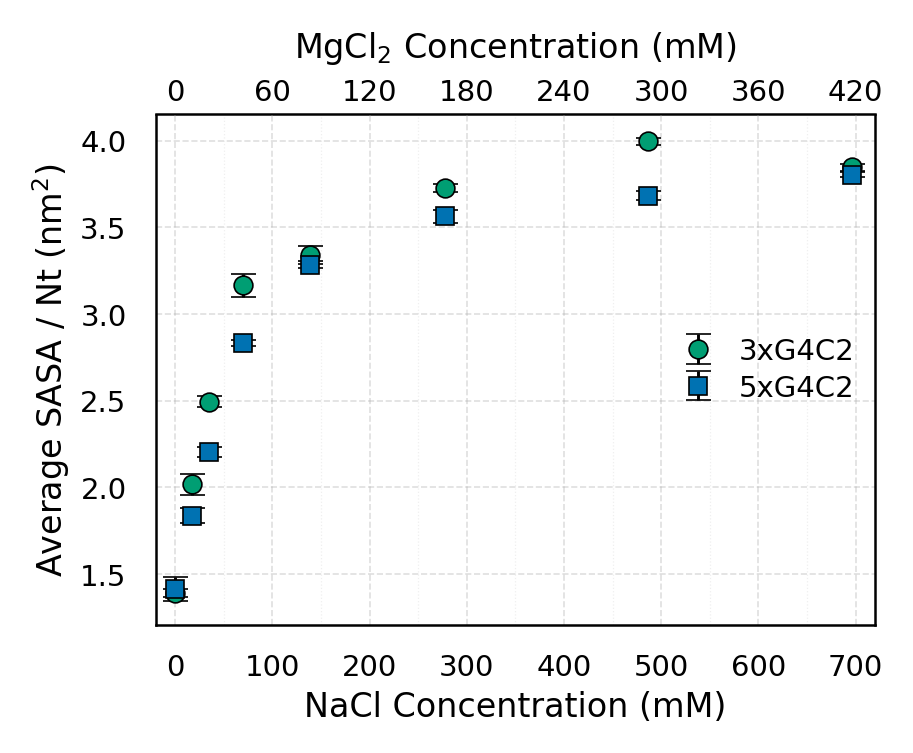

In [3]:
#%% Cell 3 - Publication-Ready Visualization 
"""
FIGURE 1i GENERATION: SASA vs. SALT CONCENTRATION

Design Specifications:
- Single-column width: 3.33 in width
- 300 DPI resolution
- CMYK-compatible colors
- Dual x-axis: NaCl (bottom) and MgCl₂ (top) concentrations
- Error bars: ±1 SD

Styling Parameters:
- Colors: Colorblind-safe palette (Okabe-Ito)
- Markers: Distinct shapes per system
- Gridlines: Major (--) and minor (:)
- Font: DejaVu Sans (embedded for PDF export)

Output Validation:
verify_publication_ready() checks:
- Minimum font size: 4.5 pt after scaling
- DPI compliance
- Boundary margins
"""
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
def create_figure(data_dict):
    """
    Generate publication-quality figure
    
    Parameters:
        data_dict (dict): Processed data from Cell 2
    
    Saves:
        '.png' in current directory
    
    Note: Output meets ACS journal figure guidelines
    """
    plt.rcParams.update({
        'font.size': 7,  # 
        'axes.labelsize': 8,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        'figure.figsize': (3.33, 2.5), 
        'axes.linewidth': 0.6,
        'lines.linewidth': 1.0,
        'lines.markeredgewidth': 0.6,
        'grid.linewidth': 0.4,
        'xtick.major.width': 0,
        'xtick.minor.width': 0,
        'ytick.major.width': 0,
        'figure.dpi' : 300,
        'savefig.dpi': 300,  
        'savefig.format': 'png',
        'pdf.fonttype': 42,
        'font.family': 'DejaVu Sans',
        'mathtext.default': 'regular'  
    })
    
    fig, ax = plt.subplots()
    colors = {
        '3xG4C2': '#009E73',  # green
        '5xG4C2': '#0072B2',  # bule
        '8xG4C2': '#E69F00'   # orange
    }
    nacl_to_mgcl2 = lambda x: x * 0.6
    mgcl2_to_nacl = lambda x: x / 0.6
    markers = {
        '3xG4C2': 'o',
        '5xG4C2': 's',
        '8xG4C2': 'D'
    }

    for idx, (condition, values) in enumerate(data_dict.items()):
        concs = sorted(values.keys())
        means = [values[c]['mean'] for c in concs]
        errors = [values[c]['std'] for c in concs]
        print(f"\n=== Condition: {condition} ===")
        for c in concs:
            print(f"Salt: {c:3d} mM | "
                  f"Global Mean: {values[c]['mean']:.4f} | "
                  f"SD: {values[c]['std']:.4f} | ")

        ax.errorbar(
            concs, means, yerr=errors,
            fmt=markers[condition],
            markersize=4.5,
            capsize=3,
            capthick=0.7,
            ecolor='black',               
            elinewidth=0.7,
            color=colors[condition],     
            markerfacecolor=colors[condition],  
            markeredgecolor='k',          
            markeredgewidth=0.4,
            label=condition,
            zorder=3
        )

    nacl_to_mgcl2 = lambda x: x * 0.6
    ax2 = ax.secondary_xaxis('top', functions=(nacl_to_mgcl2, mgcl2_to_nacl))

    ax.spines['top'].set_color('none')
    ax.set_xlabel('NaCl Concentration (mM)', labelpad=2)
    ax.set_ylabel('Average SASA / Nt (nm$^2$)', labelpad=2)
    ax2.set_xlabel('MgCl$_2$ Concentration (mM)', labelpad=5)
    ax.set_xlim(-20, 720)
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(MultipleLocator(50))
    ax2.xaxis.set_major_locator(MultipleLocator(60))
    ax2.tick_params(axis='x', which='both', length=0,  labelcolor='black',  pad=2)
    ax.grid(True, which='major', linestyle='--', linewidth=0.4, alpha=0.4)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.2)
    leg = ax.legend(
        frameon=False,
        loc='center right',
        borderpad=0.2,
        handletextpad=0.4,
        labelspacing=0.3
    )
    plt.subplots_adjust(
        left=0.18, 
        bottom=0.16, 
        top=0.84     
    )
    def verify_publication_ready(fig):
        DPI = 300
        fig_width_inch = 3.33
        min_font_pt = 4.5
        assert 7 * (3.33/3.54) >= 4.5
    verify_publication_ready(fig)
    plt.savefig(
        'Figure2b_figS2b.png',
        dpi=300,
        bbox_inches='tight',
        pad_inches=0.02, 
    )
create_figure(data)